In [45]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [74]:
lena = cv2.imread('./Images/Lena.bmp')
lena = cv2.cvtColor(lena, cv2.COLOR_BGR2RGB)
lena = np.array(lena)

baboon = cv2.imread('./Images/Baboon.bmp')
baboon = cv2.cvtColor(baboon, cv2.COLOR_BGR2RGB)
baboon = np.array(baboon)

# lena = Image.open('./Images/Lena.bmp')
# baboon = Image.open('./Images/Baboon.bmp')

In [42]:
def subplot(rows_count, column_count, images, titles):
    for i in range(len(images)):
        plt.subplot(rows_count, column_count, i+1)
        plt.title(titles[i])
        plt.imshow(images[i], cmap='gray')


In [80]:
def MSE(image1, image2):
    return np.square(np.subtract(image1, image2)).mean()


In [85]:
def PSNR(reference, reconstructed):
    # calculate MSE
    mse = MSE(reference, reconstructed)

    # calculate PSNR
    if mse == 0:
        return float('inf')
    else:
        return 10 * np.log10(255.0 ** 2 / mse)


6.1. Color space

6.1.1. Convert Lena to HSI format, and display the HIS components as separate grayscale images. Observe these images to comment on what does each of the H, S, I components represent. The HSI images should be saved in double precision.

In [12]:
def RGB_TO_HSI(img):

    with np.errstate(divide='ignore', invalid='ignore'):

        #Load image with 32 bit floats as variable type
        bgr = np.float32(img)/255

        #Separate color channels
        blue = bgr[:,:,0]
        green = bgr[:,:,1]
        red = bgr[:,:,2]

        #Calculate Intensity
        def calc_intensity(red, blue, green):
            return np.divide(blue + green + red, 3)

        #Calculate Saturation
        def calc_saturation(red, blue, green):
            minimum = np.minimum(np.minimum(red, green), blue)
            saturation = 1 - (3 / (red + green + blue + 0.001) * minimum)

            return saturation

        #Calculate Hue
        def calc_hue(red, blue, green):
            hue = np.copy(red)

            for i in range(0, blue.shape[0]):
                for j in range(0, blue.shape[1]):
                    hue[i][j] = 0.5 * ((red[i][j] - green[i][j]) + (red[i][j] - blue[i][j])) / \
                                math.sqrt((red[i][j] - green[i][j])**2 +
                                        ((red[i][j] - blue[i][j]) * (green[i][j] - blue[i][j])))
                    hue[i][j] = math.acos(hue[i][j])

                    if blue[i][j] <= green[i][j]:
                        hue[i][j] = hue[i][j]
                    else:
                        hue[i][j] = ((360 * math.pi) / 180.0) - hue[i][j]

            return hue

        #Merge channels into picture and return image
        hsi = cv2.merge((calc_hue(red, blue, green), calc_saturation(red, blue, green), calc_intensity(red, blue, green)))
        return hsi

In [15]:
# convert Lena image from RGB to HSI
lena_in_HSI = RGB_TO_HSI(lena)

# find each H, S and I component of lena image
lena_hue = lena_in_HSI[:, :, 0]
lena_saturation = lena_in_HSI[:, :, 1]
lena_intensity = lena_in_HSI[:, :, 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


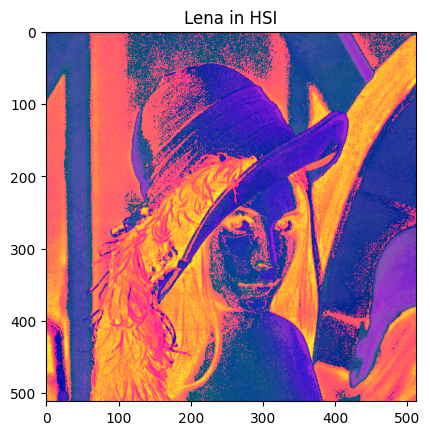

In [70]:
plt.imshow(lena_in_HSI)
plt.title('Lena in HSI')
plt.show()

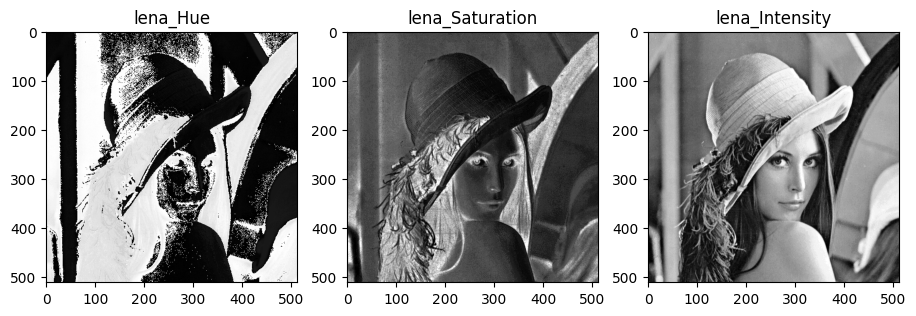

In [118]:
plt.figure(figsize=(11, 4))
subplot(1, 3,
        [lena_hue, lena_saturation, lena_intensity],
        ['lena_Hue', 'lena_Saturation', 'lena_Intensity'])


6.1.2. *Present and discuss new color space (at least three) in detail which was not introduced in class (Application, Equation, etc.).

6.2. Quantization

In [75]:
def quantize_image(image, levels_per_channel):
  # Convert the image to a NumPy array
  image_array = np.array(image)

  # Find the size of the bins for each channel
  bin_size = 256 // levels_per_channel

  # Iterate over each pixel in the image
  for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
      # Divide the intensity values by the size of the bins
      # to find which bin the intensity falls into
      binned_values = image_array[i, j] // bin_size

      # Replace the intensity values with the center value of the bins
      image_array[i, j] = bin_size * (binned_values + 0.5)

  # Convert the quantized image array back to an image and return it
  return image_array

6.2.1. Implement uniform quantization of a color image. Your program should do the following:
1. Read a grayscale image into an array.
2. Quantize and save the quantized image in a different array.
3. Compute the MSE and PSNR between the original and quantized images.
4. Display and print the quantized image.
Notice, your program should assume the input values are in the range of (0,256), but allow you to vary the reconstruction level. Record the MSE and PSNR obtained with 𝐿=64,32,16,8 and display the quantized images with corresponding 𝐿 values. Comment on the image quality as you vary 𝐿. (Test on Lena Image).

In [110]:
L_values = [64, 32, 16, 8, 4, 2]

quantized_images = []
MSE_values = []
PSNR_values = []

for L in L_values:
    quantized_lena = quantize_image(lena, L)
    quantized_images.append(quantized_lena)

    mse = MSE(lena, quantized_lena)
    MSE_values.append(mse)

    psnr = PSNR(lena, quantized_lena)
    PSNR_values.append(psnr)


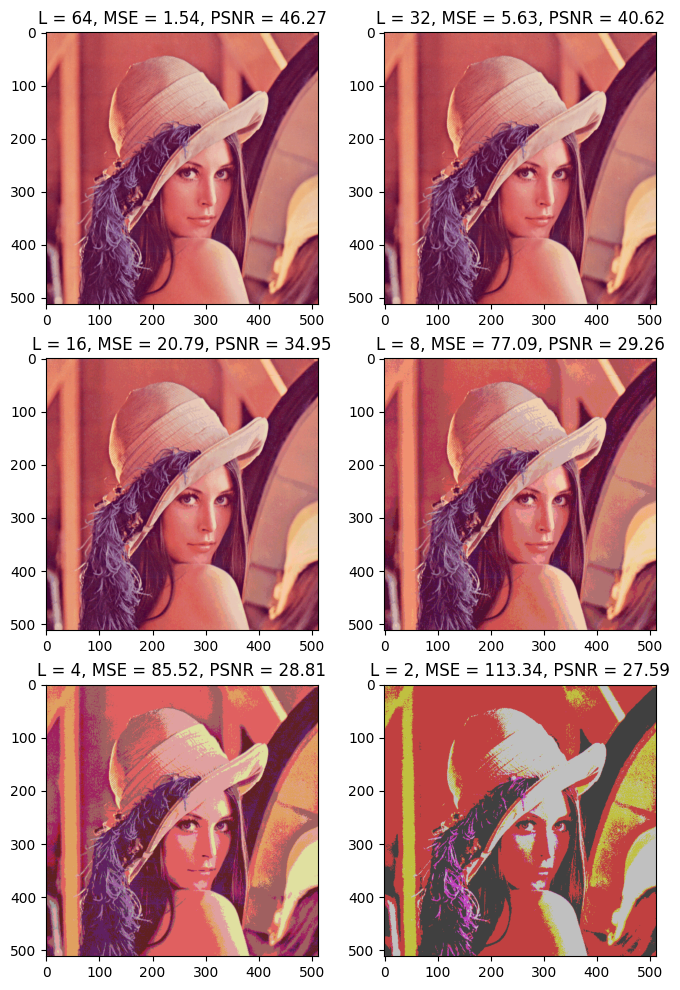

In [121]:
# Show result
plt.figure(figsize=(8, 12))
titles = []

for i in range(len(L_values)):
    titles.append('L = {}, MSE = {:.2f}, PSNR = {:.2f}'
                  .format(L_values[i], MSE_values[i], PSNR_values[i]))

subplot(3, 2, quantized_images, titles)


6.2.2. For the Lena image, quantize the R, G, and B components to 3, 3, and 2 bits, respectively, using a uniform quantizer. Display the original and quantized color image. Comment on the difference in color accuracy.

In [124]:
def quantize_RGB_channels(img, R_levels, G_levels, B_levels):
    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    
    R_quantized = quantize_image(R, R_levels)
    G_quantized = quantize_image(G, G_levels)
    B_quantized = quantize_image(B, B_levels)

    return np.dstack((R_quantized, G_quantized, B_quantized))


In [125]:
lena_RGB_quantized = quantize_RGB_channels(lena, 2**3, 2**3, 2**2)


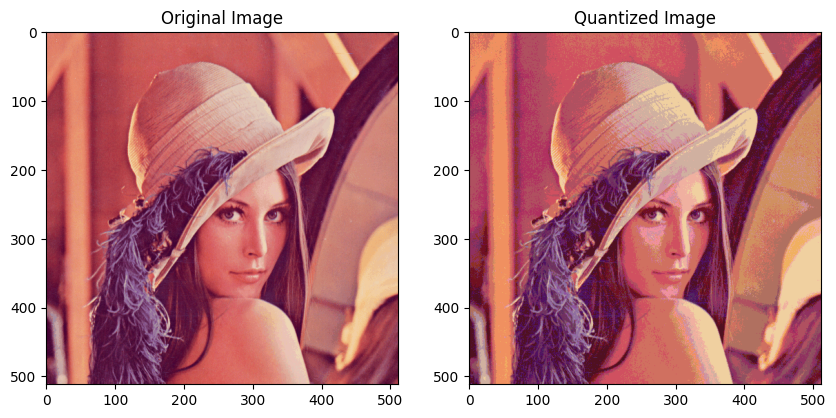

In [129]:
plt.figure(figsize=(10, 12))
subplot(1, 2, [lena, lena_RGB_quantized],
        ['Original Image', 'Quantized Image'])
